In [ ]:
import math
import torch
import torch.nn as nn
import sys
sys.path.append('..')
import myd2l

In [ ]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
    
    X = myd2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, -1e6)

    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [13]:
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])))
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 2], [3, 4]])))


tensor([[[0.5506, 0.4494, 0.0000, 0.0000],
         [0.4994, 0.5006, 0.0000, 0.0000]],

        [[0.2134, 0.4041, 0.3825, 0.0000],
         [0.2615, 0.3725, 0.3660, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3619, 0.6381, 0.0000, 0.0000]],

        [[0.2675, 0.3223, 0.4101, 0.0000],
         [0.3129, 0.2627, 0.1330, 0.2914]]])


In [17]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    # queries.shape: (batch_size, num_queries, query_size)
    # keys.shape: (batch_size, num_keys, key_size)
    # values.shape: (batch_size, num_keys, value_size)
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)

        # shape: (batch_size, num_keys, value_size)
        return torch.bmm(self.dropout(self.attention_weights), values)
        

In [19]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
print(attention(queries, keys, values, valid_lens).shape)

torch.Size([2, 1, 4])


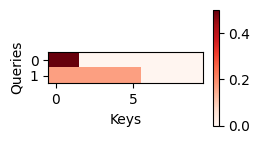

In [ ]:
myd2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [11]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries.shape: (batch_size, num_queries, d)
    # keys.shape: (batch_size, num_keys, d)
    # values.shape: (batch_size, num_keys, value_size)
    # valid_len.shape: (batch_size, ) or (batch_size, num_queries)
    def forward(self, queries, keys, values, valid_len=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_len)

        return torch.bmm(self.dropout(self.attention_weights), values)

In [12]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_len = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_len)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

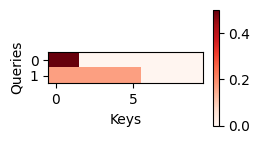

In [ ]:
myd2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')